In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import a_matrix_analysis_lib as matansys
import b_spin_representations as su2

In [2]:
N = 6
spin_ops = su2.one_body_spin_ops(N)
identity_op = spin_ops[0]
sx_list = spin_ops[1]; sy_list = spin_ops[2]; sz_list = spin_ops[3]

In [3]:
J = 1 
H = J * (sx_list[0]*sx_list[1] + sx_list[1]*sx_list[2] + sx_list[2]*sx_list[0])
H += J * (sy_list[0]*sy_list[1] + sy_list[1]*sy_list[2] + sy_list[2]*sy_list[0])
H += J * (sz_list[0]*sz_list[1] + sz_list[1]*sz_list[2] + sz_list[2]*sz_list[0])

In [4]:
def safe_expm_and_normalize(K, return_free_energy = False, tol = 1e-5):
    n_eig = sum(K.dims[0])
    if n_eig <= 16:
        e0 = max(K.eigenenergies())
    else:
        e0 = max(K.eigenenergies(sparse="True", sort = "high", eigvals = n_eig))
    sigma = (K-e0).expm()
    z = np.real(sigma.tr())
    sigma = sigma/z
    if return_free_energy: 
        f = -np.log(z) - e0;
    else:
        pass
    return sigma

In [5]:
random_no_list = [np.random.rand() for i in range(N)]

K = sum(random_no_list[m] * sx_list[m] * sx_list[(m+1) % N] for m in range(N))
K += sum(random_no_list[m] * sy_list[m] * sy_list[(m+1) % N] for m in range(N))
K += sum(random_no_list[m] * sz_list[m] * sz_list[(m+1) % N] for m in range(N))
rho0 = safe_expm_and_normalize(K)

In [6]:
def ev_checks(rho, check_positive_definite = False, tol = 1e-5):
    """
    This module checks if a qutip.Qobj, a matrix, is either positive-definite or positive semi-definite, 
    i.e. whether or not all of its eigenvalues are strictly positive or non-negative, respectively. 
    This module takes as input the following parameters:
    
        *♥*♥* 1. rho: a qutip.Qobj.
        *♥*♥* 2. check_positive_definite: an optional boolean parameter 
                                            If it is toggled on, positive-definiteness 
                                            will be checked via a Cholesky decomposition.
                                          Otherwise, only positive semi-definiteness 
                                            will be analyzed, by explicitly checking the 
                                            matrix's eigenvalues. 
        *♥*♥* 3. tol: an optional boolean parameter, used only when positive semi-definiteness
                       is being analyzed, by establishing an upper bound on the smallest eigenvalue. 
        
        ====> Returns: a boolean, its truth value
                                  being whether or not 
                                  rho is a positive-definite
                                  matrix. 
        Warnings: None.
    """
    if isinstance(rho, qutip.Qobj):
        pass
    else:
        rho = qutip.Qobj(rho)
    
    if check_positive_definite: 
        try:
            rho = rho.full()
            np.linalg.cholesky(rho)
        except:
            return False
        return True
    else:
        ev_list = rho.eigenenergies()
        ev_list = sorted(rho.eigenenergies())
        min_ev = min(ev_list); ev_list = None
        if min_ev < tol:
            return False
        else:
            return True
    return True
        
def is_density_op(rho, verbose=False, critical=False, tol = 1e-3):
    """
    This module checks if the user-input QuTip.Qobj, rho, is a density operator or not. This is done 
    by checking if it is a hermitian, positive semi-definite, and trace-one, matrix. 
    This module takes as input the following parameters:
    
        *♥*♥* 1. rho: a qutip.Qobj,
        *♥*♥* 2. verbose: an optional boolean parameter for printing out logs,
                          stating which tests rho hasn't passed,
        *♥*♥* 3. critical: an optional boolean parameter.
        *♥*♥* 4. tol: an optional boolean parameter for establishing a maximum tolerance 
                        for numerical errors, when computing rho's trace. 
                        See Warnings further below.
       
        ====> Returns: a boolean, its truth value
                                  being whether or not 
                                  rho is a density matrix.
                                  
        Warnings: Due to numerical instabilities, it may be possible for the trace 
                  to not be exactly one, even though it is supposed to be. 
                  Therefore, a cut-off is implemented to check this condition.
    """
    if not qutip.isherm(rho):
        if verbose:
            print("rho is not hermitian")
        assert not critical
        return False
    if abs(1 - rho.tr()) > tol:
        if verbose:
            print("Tr rho != 1, Tr rho = ", rho.tr())
        assert not critical
        return False
    if not ev_checks(rho):
        if verbose:
            print("rho is not positive")
        assert not critical
        return False
    return True

In [7]:
def logM(rho, svd = True):
    """
    Evaluates the logarithm of a positive matrix rho.
    """
    assert ev_checks(rho), "Non positive-defined input matrix"
    if isinstance(rho, qutip.Qobj):
        qutip_form = True
        dims = rho.dims
    else:
        qutip_form = False        

    if svd:            
        if qutip_form:
            rho = rho.full()
        U, Sigma, Vdag = linalg.svd(rho, full_matrices = False)
        matrix_log = U @ np.diag(np.log(Sigma)) @ U.conj().transpose() 
    else: 
        if qutip_form:
            eigvals, eigvecs = rho.eigenstates()
            matrix_log = sum([np.log(vl)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs)]) 
        else:
            rho = rho.full()
            eigvals, eigvecs = linalg.eigh(rho)
            return evecs @ np.array([np.log(ev)*np.array(f) for ev, f in zip(evals, evecs.transpose().conj())])
    
    if qutip_form:
        matrix_log = qutip.Qobj(matrix_log, dims)
    return matrix_log

def sqrtM(rho, svd = True):
    """
    Evaluates the square root of a positive matrix rho.
    """
    assert ev_checks(rho), "Non positive-defined input matrix"
    if isinstance(rho, qutip.Qobj):
        qutip_form = True
        dims = rho.dims
    else:
        qutip_form = False

    if svd:
        if qutip_form:
            rho = rho.full()
        U, Sigma, Vdag = linalg.svd(rho, full_matrices = False)
        matrix_log = U @ np.diag((Sigma)**.5) @ U.conj().transpose() 
    else: 
        if qutip_form:
            eigvals, eigvecs = rho.eigenstates()
            matrix_log = sum([(vl**.5)*vc*vc.dag() for vl, vc in zip(eigvals, eigvecs)]) 
        else:
            rho = rho.full()
            eigvals, eigvecs = linalg.eigh(rho)
            return evecs @ np.array([(ev**.5)*np.array(f) for ev, f in zip(evals, evecs.transpose().conj())])
    
    if qutip_form:
        matrix_log = qutip.Qobj(matrix_log, dims)
    return matrix_log

In [8]:
def bures(rho, sigma, svd = True):
    """
    Evaluates the Bures metric between two density states. 
    """
    assert is_density_op(rho), "rho is not a density operator"
    assert is_density_op(sigma), "sigma is not a density operator"
    
    sqrt_sigma = sqrtM(sigma.full(), svd=svd)
    
    fidelity = sqrtM((sqrt_sigma @ rho.full()  @sqrt_sigma),svd=True).trace().real

    assert abs(fidelity.imag)<1.e-10, f"complex fidelity? fidelity={fidelity}"
    fidelity = fidelity.real
    assert 0 <= fidelity, f"negative fidelity? fidelity={fidelity}"
    if fidelity>1.05:
        assert (fidelity-1)<1.e-8, f"error in fidelity too large fidelity={fidelity}"
        return 0.
    return  np.arccos(fidelity)/np.pi

def rel_entropy(rho, sigma, svd = True):
    if svd:
        val = (rho*(logM(rho, True) - logM(sigma, True))).tr()
    else:
        assert ((ev_checks(rho) and ev_checks(sigma))), "Either rho or sigma have negative ev."
        val = (rho*(logM(rho, False)-logM(sigma, False))).tr()
        if (abs(val.imag - 0)>1.e-10):
            val = None
            raise Exception("Either rho or sigma have negative ev.")
    return val.real

In [9]:
def mean_field_iteration(rho0, guesstimates, basis, steps):
    trial_K = sum(phi * op for phi,op in zip(guesstimates, basis))
    sigma0 = safe_expm_and_normalize(trial_K)
    mft_states = [sigma0]
    for i in range(1, steps):
        sigma_mft = mft_states[i-1]
        coeff_list_j = [qutip.expect(sigma_mft, op) for op in basis]
        K_j = sum(zeta_j_i * op_i for zeta_j_i, op_i in zip(coeff_list_j, basis))
        sigma_j = safe_expm_and_normalize(K_j)
        mft_states.append(sigma_j)
        coeff_list_j = K_j = sigma_j = None
        
    return mft_states

In [18]:
basis = sx_list 
guesstimate = [1] + [0 for i in range(len(basis) - 1)]
trial_K = sum(zeta * op for zeta, op in zip(random_no_list, basis))

iteration = [i for i in range(1, 11)]
mftstates = mean_field_iteration(rho0 = rho0, guesstimates = guesstimate,
                                 basis = basis, steps = 10)

frobenius_norm = [linalg.norm(rho0 - sigma0i) for sigma0i in mftstates]
relentr = [rel_entropy(rho0, sigma0i, svd = True) for sigma0i in mftstates]
bures_dist = [bures(rho0, sigma0i, svd = True) for sigma0i in mftstates]

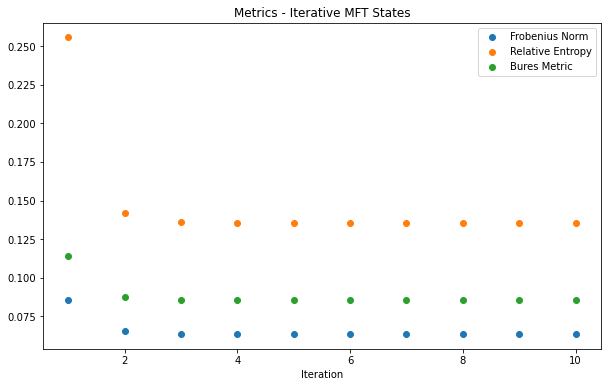

In [19]:
fig0, ax0 = plt.subplots(figsize=(10,6))
plt.title("Metrics - Iterative MFT States")

plt.scatter(iteration, frobenius_norm, label = "Frobenius Norm")
plt.scatter(iteration, relentr, label = "Relative Entropy")
plt.scatter(iteration, bures_dist, label = "Bures Metric")

ax0.legend(loc=0)
plt.xlabel("Iteration")
plt.show()

# Dependence with dimension

In [51]:
number_of_spins = [i for i in range(3, 9)]
number_of_spins

[3, 4, 5, 6, 7, 8]

In [47]:

list_of_spin_ops = [su2.one_body_spin_ops(N) for N in number_of_spins]
list_of_identity_ops = [list_of_spin_ops[k][0] for k in range(len(number_of_spins))]

list_of_sx_lists = [list_of_spin_ops[k][1] for k in range(len(number_of_spins))]
list_of_sy_lists = [list_of_spin_ops[k][2] for k in range(len(number_of_spins))]
list_of_sy_lists = [list_of_spin_ops[k][3] for k in range(len(number_of_spins))]




SyntaxError: invalid syntax (1279391746.py, line 13)

In [57]:
random_no_list = [[np.random.rand() for i in range(N)] for N in number_of_spins]

In [63]:
list_of_Hamiltonians = [
                         sum(random_no_list[N][m] * list_of_sx_lists[N][m] * list_of_sx_lists[N][(m+1) % N])
                         for m in range(N) for N in number_of_spins       
                            ]

IndexError: list index out of range

In [56]:
len(list_of_sx_lists[5])

8

In [ ]:
random_no_list = [np.random.rand() for i in range(N)]

K = sum(random_no_list[m] * sx_list[m] * sx_list[(m+1) % N] for m in range(N))
K += sum(random_no_list[m] * sy_list[m] * sy_list[(m+1) % N] for m in range(N))
K += sum(random_no_list[m] * sz_list[m] * sz_list[(m+1) % N] for m in range(N))
rho0 = safe_expm_and_normalize(K)

In [37]:
su2.one_body_spin_ops(3)[3][0]
spin_ops = su2.one_body_spin_ops(N)
identity_op = spin_ops[0]
sx_list = spin_ops[1]; sy_list = spin_ops[2]; sz_list = spin_ops[3]


J = 1 
H = J * (sx_list[0]*sx_list[1] + sx_list[1]*sx_list[2] + sx_list[2]*sx_list[0])
H += J * (sy_list[0]*sy_list[1] + sy_list[1]*sy_list[2] + sy_list[2]*sy_list[0])
H += J * (sz_list[0]*sz_list[1] + sz_list[1]*sz_list[2] + sz_list[2]*sz_list[0])

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5]]

In [ ]:

spin_ops = su2.one_body_spin_ops(N)
identity_op = spin_ops[0]
sx_list = spin_ops[1]; sy_list = spin_ops[2]; sz_list = spin_ops[3]

In [82]:
mftstates[0].dims == rho0.dims

True

In [74]:
[type(op) for op in mftstates]

[qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj]

In [12]:
frobenius_norm

[0.05776442534249243,
 0.043387391130636,
 0.010783930436370562,
 0.0026950077831791965,
 0.0006737367221242927,
 0.00016843394266901398,
 4.2108481950666385e-05,
 1.0527120429594939e-05,
 2.631780106491363e-06,
 6.579450266086632e-07]

In [13]:
distances

NameError: name 'distances' is not defined

In [17]:
basis = sx_list 
guesstimate = [1] + [0 for i in range(len(basis) - 1)]
trial_K = sum(zeta * op for zeta, op in zip(random_no_list, basis))
sigma0 = safe_expm_and_normalize(trial_K)

coeff_list1 = [qutip.expect(sigma0, op) for op in basis]
K1 = sum(zeta1 * op for zeta1, op in zip(coeff_list1, basis))
sigma1 = safe_expm_and_normalize(K1)

print(linalg.norm(rho0 - sigma1))
print(linalg.norm(rho0 - sigma0))

0.054975379315586215
0.08358489970852746


In [11]:
basis_of_basis = [sx_list, sy_list, sz_list]
trial_Ks = [sum(zeta * op for zeta, op in zip(random_no_list, basis)) for basis in basis_of_basis]
sigma0s = [safe_expm_and_normalize(K0, False) for K0 in trial_Ks]

mft_coefficients = []
for sigma0_i, basis_i in zip(sigma0s, basis_of_basis):
    local_list = [qutip.expect(sigma0_i, op) for op in basis_i]
    mft_coefficients.append(local_list)
    local_list = None

first_iteration_Ks = []
for mft_coefficients_i, basis_i in zip(mft_coefficients, basis_of_basis):
    local_K = sum(zeta_j * op_j for zeta_j, op_j in zip(mft_coefficients_i, basis_i))
    first_iteration_Ks.append(local_K)
    local_K = 0
    
first_iterations_mft_states = [safe_expm_and_normalize(K1, False) for K1 in first_iteration_Ks] 
initial_distances = [linalg.norm(rho0 - sigma0) for sigma0 in sigma0s]
first_iteration_distances = [linalg.norm(rho0 - sigma1) for sigma1 in first_iterations_mft_states]

In [12]:
initial_distances

[0.08358489970852746, 0.08358489970852745, 0.08358489970852737]

In [13]:
first_iteration_distances

[0.054975379315586215, 0.0549753793155862, 0.05497537931558619]

In [ ]:
### ERROR ACA

In [42]:
trial_Ks[1]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.-0.4013647j  0.-0.2940203j  0.+0.j
  0.-0.47113643j 0.+0.j         0.+0.j         0.+0.j        ]
 [0.+0.4013647j  0.+0.j         0.+0.j         0.-0.2940203j
  0.+0.j         0.-0.47113643j 0.+0.j         0.+0.j        ]
 [0.+0.2940203j  0.+0.j         0.+0.j         0.-0.4013647j
  0.+0.j         0.+0.j         0.-0.47113643j 0.+0.j        ]
 [0.+0.j         0.+0.2940203j  0.+0.4013647j  0.+0.j
  0.+0.j         0.+0.j         0.+0.j         0.-0.47113643j]
 [0.+0.47113643j 0.+0.j         0.+0.j         0.+0.j
  0.+0.j         0.-0.4013647j  0.-0.2940203j  0.+0.j        ]
 [0.+0.j         0.+0.47113643j 0.+0.j         0.+0.j
  0.+0.4013647j  0.+0.j         0.+0.j         0.-0.2940203j ]
 [0.+0.j         0.+0.j         0.+0.47113643j 0.+0.j
  0.+0.2940203j  0.+0.j         0.+0.j         0.-0.4013647j ]
 [0.+0.j         0.+0.j         0.+0.j         0.+0.47113643j
  0

In [38]:
linalg.norm(trial_Ks[0] - trial_Ks[1])

2.7408351979994605

In [29]:
initial_distances

[0.2763714463310511, 0.2763714463310512, 0.2763714463310512]

In [30]:
first_iteration_distances

[0.18501328855051866, 0.18501328855051866, 0.1908517141103419]

In [7]:
def mean_field_state(rho0, basis, init_guesstimates, steps):
    
    trial_K = sum(zeta * op for zeta, op in zip(random_no_list, basis))
    sigma0 = safe_expm_and_normalize(trial_K, False)
    mft_states = [sigma0]
    for i in range(1, steps):
        sigma_mft = mft_states[i-1]
        coeff_list_j = [qutip.expect(sigma_mft, op) for op in basis]
        K_j = sum(zeta_j * op for zeta_j, op in zip(coeff_list_j, basis))
        sigma_j = safe_expm_and_normalize(K_j, False)
        mft_states.append(sigma_j)
    
    return mft_states

In [8]:
mft_states = mean_field_state(rho0, basis, random_no_list, 10)
distances = [linalg.norm(rho0 - mftstate) for mftstate in mft_states]

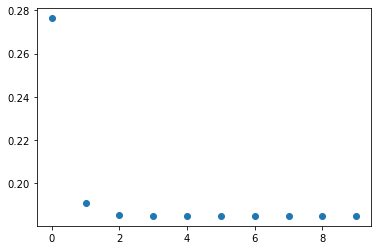

In [9]:
plt.scatter([i for i in range(10)], distances)

In [ ]:
1. Que pasa si uso un mal estado?
2. Que pasa si uso coeficientes no aleatorios? Lejos y cercanos
3. Como se ve en la metrica KMB y la rel entr
4. Donde entra en juego las bases jerárquicas?
5. Que pasa si uso otros estados??